In [1]:
!git clone https://github.com/OmarElmelegy/Jamming_Detection_SDR.git

Cloning into 'Jamming_Detection_SDR'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47 (from 1)
Receiving objects: 100% (47/47), 41.71 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
import os

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Print current working directory to understand file paths
print("Current working directory:", os.getcwd())

Current working directory: /content


In [10]:
# Define paths to the dataset files
normal_path = "./Jamming_Detection_SDR/Dataset/test/Test_Rssi_Normal.txt"
cj_path = "./Jamming_Detection_SDR/Dataset/test/Test_Rssi_CJ.txt"
pj_path = "./Jamming_Detection_SDR/Dataset/test/Test_Rssi_PJ.txt"

# Function to load the data
def load_data(file_path):
    try:
        data = np.loadtxt(file_path)
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.array([])

# Load the datasets
normal_data_raw = load_data(normal_path)
cj_data_raw = load_data(cj_path)
pj_data_raw = load_data(pj_path)

print(f"Raw Normal data shape: {normal_data_raw.shape}")
print(f"Raw Constant Jammer data shape: {cj_data_raw.shape}")
print(f"Raw Pulsed Jammer data shape: {pj_data_raw.shape}")

# --- Corrected Data Preparation Logic ---
num_samples_per_signal = 1000 # Sequence length, same as in training notebook

# Calculate how many complete signals we can extract
normal_signals_count = normal_data_raw.shape[0] // num_samples_per_signal
cj_signals_count = cj_data_raw.shape[0] // num_samples_per_signal
pj_signals_count = pj_data_raw.shape[0] // num_samples_per_signal

# Reshape so each row is one signal of length 1000
normal_data_reshaped = normal_data_raw[:normal_signals_count * num_samples_per_signal].reshape((normal_signals_count, num_samples_per_signal))
cj_data_reshaped = cj_data_raw[:cj_signals_count * num_samples_per_signal].reshape((cj_signals_count, num_samples_per_signal))
pj_data_reshaped = pj_data_raw[:pj_signals_count * num_samples_per_signal].reshape((pj_signals_count, num_samples_per_signal))

print(f"Reshaped Normal signals: {normal_data_reshaped.shape}")
print(f"Reshaped Constant Jammer signals: {cj_data_reshaped.shape}")
print(f"Reshaped Pulsed Jammer signals: {pj_data_reshaped.shape}")

# Determine number of test samples per class
# Aiming for a balanced test set of around 200 total samples, similar to your original notebook 2
num_test_samples_per_class = 200 # This will give 66*3 = 198 samples

# Ensure we don't request more samples than available from any class
num_test_samples_per_class = min(num_test_samples_per_class, normal_signals_count, cj_signals_count, pj_signals_count)

if num_test_samples_per_class == 0:
    raise ValueError(f"Not enough reshaped signals (with {num_samples_per_signal} samples each) to create a test set. Check raw data sizes.")

# Select random sequences for each class for the test set
# Note: Notebook 1 used a train/test split. Here we are creating a new test set.
# If you want to use the exact test set from Notebook 1, you'd need to save/load those specific indices or data.
# For now, we'll select random sequences from the available reshaped data.
normal_indices_test = np.random.choice(normal_data_reshaped.shape[0], num_test_samples_per_class, replace=False)
cj_indices_test = np.random.choice(cj_data_reshaped.shape[0], num_test_samples_per_class, replace=False)
pj_indices_test = np.random.choice(pj_data_reshaped.shape[0], num_test_samples_per_class, replace=False)

normal_test_samples = normal_data_reshaped[normal_indices_test]
cj_test_samples = cj_data_reshaped[cj_indices_test]
pj_test_samples = pj_data_reshaped[pj_indices_test]

# Create labels (0: Normal, 1: Constant Jammer, 2: Pulsed Jammer)
normal_labels_test = np.zeros(num_test_samples_per_class, dtype=int)
cj_labels_test = np.ones(num_test_samples_per_class, dtype=int)
pj_labels_test = np.full(num_test_samples_per_class, 2, dtype=int)

# Combine samples and labels for X_test and y_test
X_test = np.concatenate([normal_test_samples, cj_test_samples, pj_test_samples], axis=0)
y_test = np.concatenate([normal_labels_test, cj_labels_test, pj_labels_test]) # This is y_test_numeric

print(f"X_test shape before final reshape for Conv1D: {X_test.shape}")
print(f"y_test (numeric) shape: {y_test.shape}")
print(f"Class distribution in y_test: {np.bincount(y_test.astype(int))}")

Raw Normal data shape: (236288,)
Raw Constant Jammer data shape: (231192,)
Raw Pulsed Jammer data shape: (232258,)
Reshaped Normal signals: (236, 1000)
Reshaped Constant Jammer signals: (231, 1000)
Reshaped Pulsed Jammer signals: (232, 1000)
X_test shape before final reshape for Conv1D: (600, 1000)
y_test (numeric) shape: (600,)
Class distribution in y_test: [200 200 200]


In [11]:
# Load the saved model from the model directory
model_path = "./Jamming_Detection_SDR/model/model_NewDataset.h5"

# Try to load the model with custom_objects parameter
model = load_model(model_path, compile=True)
print(f"Successfully loaded model from {model_path}")
# Display model summary
model.summary()

Successfully loaded model from ./Jamming_Detection_SDR/model/model_NewDataset.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 998, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 996, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 996, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127488)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       382,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,261 (1.65 MB)

 Trainable params: 432,259 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [12]:
# Check the model's input shape requirements
def get_model_input_shape(model):
    """Extract the expected input shape from the model"""
    try:
        # Get the model's input shape directly
        input_shape = model.input_shape
        return input_shape
    except AttributeError:
        # Fallback: try to get the input shape from the first layer's input
        try:
            first_layer = model.layers[0]
            # For functional models or some layer types
            return first_layer.input_shape
        except AttributeError:
            # Last resort: get from the model's input spec
            # This handles cases where the model is not built yet or input_shape is None
            return model.inputs[0].shape

# Call the function to get the input shape
input_shape = get_model_input_shape(model)

print(f"Model expects input shape: {input_shape}")

# This function will be used after loading the model

Model expects input shape: (None, 1000, 1)


## Reshaping

In [13]:
# Reshape X_test to match model input requirements
# Check the dimensionality requirements
if input_shape[1] is not None:  # If the model expects a specific sequence length
    # Get sample dimensionality
    sample_dim = X_test.shape[1] if len(X_test.shape) > 1 else 1

    # If samples are 1D and model expects 2D or 3D input
    if len(input_shape) >= 3:
        # Reshape to (samples, sequence_length, features)
        # For Conv1D, we need at least 3 time steps for a kernel size of 3
        sequence_length = max(3, input_shape[1]) if input_shape[1] is not None else 3

        # If each sample is just a single value, we need to expand it
        if sample_dim == 1:
            print("Expanding single values to sequences...")
            # Create sequences by repeating each value
            X_test_expanded = np.repeat(X_test, sequence_length).reshape(-1, sequence_length)
            # Add feature dimension if needed
            if len(input_shape) == 3:  # Model expects (batch, seq_len, features)
                X_test = X_test_expanded.reshape(-1, sequence_length, 1)
            else:
                X_test = X_test_expanded
        else:
            # If samples already have multiple values, reshape appropriately
            if len(input_shape) == 3:  # Model expects (batch, seq_len, features)
                X_test = X_test.reshape(-1, X_test.shape[1], 1)

    # If the model just expects a flattened input
    elif len(input_shape) == 2:  # Model expects (batch, features)
        X_test = X_test.reshape(X_test.shape[0], -1)

print(f"Reshaped test data to: {X_test.shape}")

Reshaped test data to: (600, 1000, 1)


In [14]:
# Make predictions on the test data
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1) if y_pred_probs.shape[1] > 1 else np.round(y_pred_probs).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Display detailed classification report
print("\nClassification Report:")
target_names = ['Normal', 'Constant Jammer', 'Pulsed Jammer']
print(classification_report(y_test, y_pred, target_names=target_names))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Accuracy: 0.9200

Confusion Matrix:
[[200   0   0]
 [  1 152  47]
 [  0   0 200]]

Classification Report:
                 precision    recall  f1-score   support

         Normal       1.00      1.00      1.00       200
Constant Jammer       1.00      0.76      0.86       200
  Pulsed Jammer       0.81      1.00      0.89       200

       accuracy                           0.92       600
      macro avg       0.93      0.92      0.92       600
   weighted avg       0.93      0.92      0.92       600



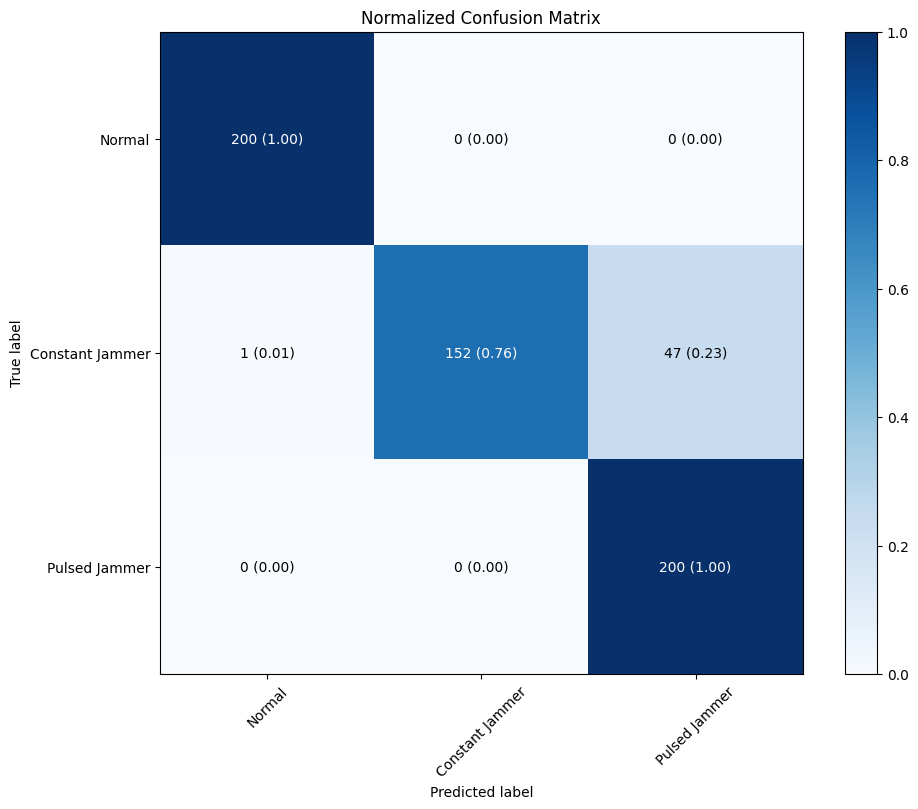

In [15]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 8))

# Use a color map that makes it clear which values are higher
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Add text annotations to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]} ({cm_normalized[i, j]:.2f})",
                 ha="center", va="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

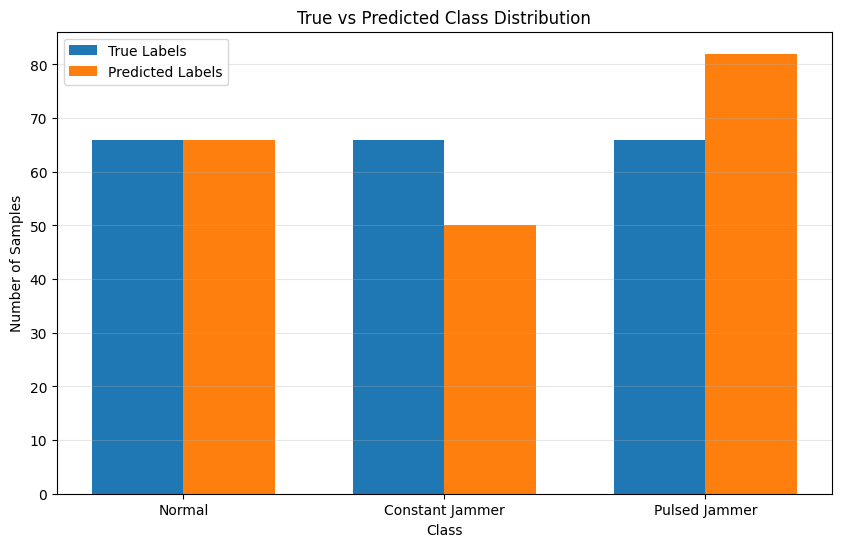

In [9]:
# Create a bar chart comparing true vs predicted class distribution
plt.figure(figsize=(10, 6))

true_counts = np.bincount(y_test.astype(int), minlength=3)
pred_counts = np.bincount(y_pred.astype(int), minlength=3)

x = np.arange(len(target_names))
width = 0.35

plt.bar(x - width/2, true_counts, width, label='True Labels')
plt.bar(x + width/2, pred_counts, width, label='Predicted Labels')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('True vs Predicted Class Distribution')
plt.xticks(x, target_names)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()